# Content and Objectives

- Show pulse shaping (rect and raised-cosine) for random data
- Spectra are determined based on the theoretical pulse shape as well as for the random signals when applying estimation

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

# Function for determining the impulse response of an RC filter

In [3]:
########################
# find impulse response of an RC filter
########################
def get_rc_ir(K, n_sps, t_symbol, r):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero r to close-to-zero
    if r == 0:
        r = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_sps
    
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1. / t_symbol
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * r ):
            rc[ k ] = r / ( 2.0 * t_symbol ) * np.sin( np.pi / ( 2.0 * r ) )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k] / t_symbol ) / np.pi / t_steps[k] \
                * np.cos( r * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * r * t_steps[k] / t_symbol )**2 )
 
    return rc

# Parameters

In [4]:
# modulation scheme and constellation points
M = 2
constellation_points = [ -1, 1 ]

# symbol time and number of symbols    
t_symb = 1.0
n_symb = 100
 

# parameters of the RRC filter
r = .33

n_sps = 8            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter


# parameters for frequency regime
N_fft = 512
Omega = np.linspace( -np.pi, np.pi, N_fft)
f_vec = Omega / ( 2 * np.pi * t_symb / n_sps )

# Signals and their spectra

In [5]:
# get RC pulse and rectangular pulse,
# both being normalized to energy 1
rc = get_rc_ir( K_filt, n_sps, t_symb, r )
rc /= np.linalg.norm( rc ) 

rect = np.append( np.ones( n_sps ), np.zeros( len( rc ) - n_sps ) )
rect /= np.linalg.norm( rect )


# get pulse spectra
RC_PSD = np.abs( np.fft.fftshift( np.fft.fft( rc, N_fft ) ) )**2
RC_PSD /= n_sps

RECT_PSD = np.abs( np.fft.fftshift( np.fft.fft( rect, N_fft ) ) )**2
RECT_PSD /= n_sps


# Real data-modulated Tx-signal

In [6]:
# number of realizations along which to average the psd estimate
n_real = 10

# initialize two-dimensional field for collecting several realizations along which to average 
S_rc = np.zeros( (n_real, N_fft ), dtype=complex ) 
S_rect = np.zeros( (n_real, N_fft ), dtype=complex )


# loop for multiple realizations in order to improve spectral estimation
for k in range( n_real ):

    # generate random binary vector and 
    # modulate the specified modulation scheme
    data = np.random.randint( M, size = n_symb )
    s = [ constellation_points[ d ] for d in data ]

    # apply RC filtering/pulse-shaping
    s_up_rc = np.zeros( n_symb * n_sps )        
    s_up_rc[ : : n_sps ] = s

    s_rc = np.convolve( rc, s_up_rc)

    
    # apply RECTANGULAR filtering/pulse-shaping
    s_up_rect = np.zeros( n_symb * n_sps )      
    s_up_rect[ : : n_sps ] = s

    s_rect = np.convolve( rect, s_up_rect)        

    
    # get spectrum using Bartlett method
    S_rc[k, :] = np.fft.fftshift( np.fft.fft( s_rc, N_fft ) )
    S_rect[k, :] = np.fft.fftshift( np.fft.fft( s_rect, N_fft ) )


# average along realizations
RC_PSD_sim = np.average( np.abs( S_rc )**2, axis=0 )
RC_PSD_sim /= np.max( RC_PSD_sim )

RECT_PSD_sim = np.average( np.abs( S_rect )**2, axis=0 ) 
RECT_PSD_sim /= np.max( RECT_PSD_sim )

# Plotting

(-60, 10)

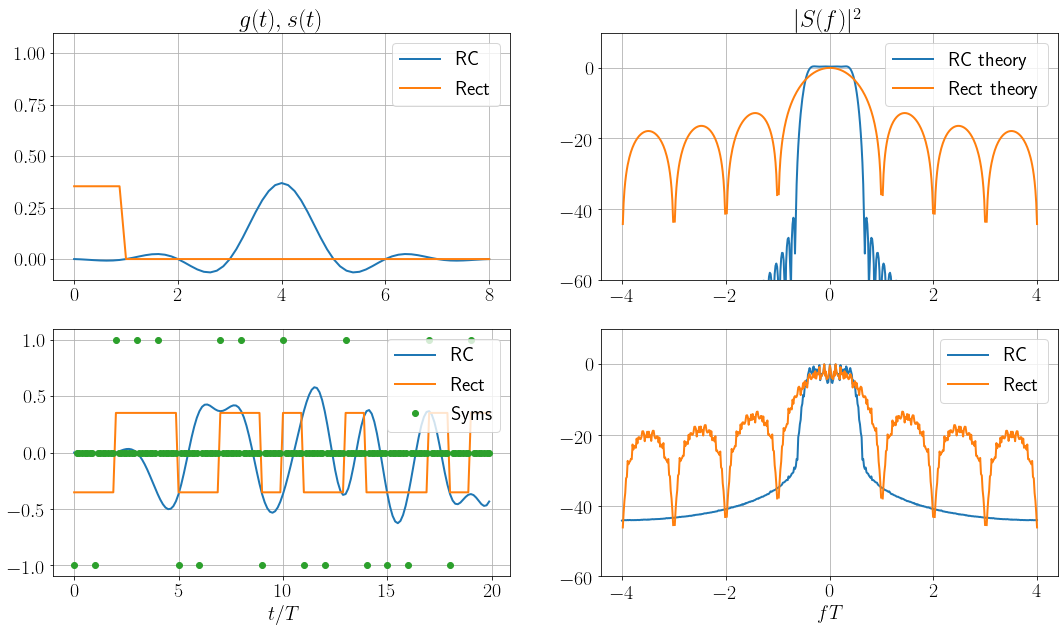

In [8]:
plt.subplot(221)

plt.plot( np.arange( np.size( rc ) ) * t_symb / n_sps, rc, linewidth=2.0, label='RC' )
plt.plot( np.arange( np.size( rect ) ) * t_symb / n_sps, rect, linewidth=2.0, label='Rect' )

plt.ylim( (-.1, 1.1 ) ) 
plt.grid( True )
plt.legend( loc='upper right' )    
plt.title( '$g(t), s(t)$' )


plt.subplot(222)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_vec, 10*np.log10( RC_PSD ), linewidth=2.0, label='RC theory' ) 
plt.plot( f_vec, 10*np.log10( RECT_PSD ), linewidth=2.0, label='Rect theory' ) 
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid( True )    
plt.legend( loc='upper right' )    
plt.title( '$|S(f)|^2$' )    
plt.ylim( (-60, 10 ) )


plt.subplot(223)

# upper limit for number of symbols shown in the plot
ul = 20 * n_sps
plt.plot( np.arange( np.size( s_rc[ : ul ])) * t_symb / n_sps, s_rc[ : ul ], linewidth=2.0, label='RC' )
plt.plot( np.arange( np.size( s_rect[ : ul ])) * t_symb / n_sps, s_rect[ : ul ], linewidth=2.0, label='Rect' )   
plt.plot( np.arange( np.size( s_up_rc[ : ul ])) * t_symb / n_sps, s_up_rc[ : ul ], 'o', linewidth=2.0, label='Syms' )

plt.ylim( (-1.1, 1.1 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$t/T$')


plt.subplot(224)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( f_vec, 10*np.log10( RC_PSD_sim ), linewidth=2.0, label='RC' )
plt.plot( f_vec, 10*np.log10( RECT_PSD_sim ), linewidth=2.0, label='Rect' ) 
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True); 
plt.xlabel('$fT$');  
plt.legend(loc='upper right')
plt.ylim( (-60, 10 ) )